# A Learned Weight-Based Study of Music Influence through Network Analysis




This project aims to quantify and understand the musical evolution and influence of musical artists in human societies. The goal is to measure the impact that previously produced music has on new music and musical artists. The project will use network analysis to understand the relationships between musical artists and their influences on each other. The project will take into account factors such as song characteristics to determine their potential influence on each other. The project aims to identify the most influential musical artists and genres and to understand the role they have played in the collective human experience of music.

## Getting the data ready

We are provided with two csv files. The first task is to convert the table based data into a network graph of artists and their influence. 

In [40]:
import pandas as pd
import networkx as nx
from tabulate import tabulate
from networkx.readwrite import write_gexf
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(100)


In [2]:
# Load the datasets
influence_data = pd.read_csv("Data/influence_data.csv")
data_by_artist = pd.read_csv("Data/data_by_artist.csv")


In [3]:
influence_data.head()

,influencer_id,influencer_name,influencer_main_genre,influencer_active_start,follower_id,follower_name,follower_main_genre,follower_active_start
0,759491,The Exploited,Pop/Rock,1980,74,Special Duties,Pop/Rock,1980
1,25462,Tricky,Electronic,1990,335,PJ Harvey,Pop/Rock,1990
2,66915,Bob Dylan,Pop/Rock,1960,335,PJ Harvey,Pop/Rock,1990
3,71209,Leonard Cohen,Pop/Rock,1950,335,PJ Harvey,Pop/Rock,1990
4,91438,The Gun Club,Pop/Rock,1980,335,PJ Harvey,Pop/Rock,1990


In [4]:
data_by_artist.head()

,artist_name,artist_id,danceability,energy,valence,tempo,loudness,mode,key,acousticness,instrumentalness,liveness,speechiness,duration_ms,popularity,count
0,Frank Sinatra,792507,0.384478,0.238017,0.364288,110.181698,-14.271141,1,5,0.735648,0.020855,0.232106,0.049614,189179.9255,26.004383,1369
1,Vladimir Horowitz,119107,0.343210,0.118844,0.225951,94.900679,-23.193418,1,1,0.990070,0.879508,0.183812,0.043360,266541.1251,3.592378,1207
2,Johnny Cash,816890,0.619803,0.449381,0.680662,115.037747,-11.593104,1,10,0.685637,0.022647,0.242243,0.098216,162279.2672,26.614130,1104
3,Billie Holiday,79016,0.572637,0.201368,0.498934,109.912172,-13.225966,1,5,0.908499,0.013064,0.217727,0.062432,185131.4530,15.621005,1095
4,Bob Dylan,66915,0.512598,0.477932,0.551934,126.160149,-11.184330,1,7,0.562567,0.034211,0.308978,0.064535,256713.4203,30.860806,1092


The "influence_data" dataset contains information about musical influencers and followers, including artist identification numbers, names, main genres, and active start decade. The "data_by_artist" dataset contains musical characteristics of tracks produced by each artist, such as danceability, energy, valence, tempo, loudness, and others.

### Creating a Directed Network 

In [5]:
# Create a dictionary for artist genres and years
artist_genres = dict(zip(influence_data['influencer_id'], influence_data['influencer_main_genre']))
artist_years = dict(zip(influence_data['influencer_id'], influence_data['influencer_active_start']))
artist_genres.update(dict(zip(influence_data['follower_id'], influence_data['follower_main_genre'])))
artist_years.update(dict(zip(influence_data['follower_id'], influence_data['follower_active_start'])))

In [6]:
# Create the directed graph
G = nx.DiGraph()

# Add nodes with attributes
for idx, row in data_by_artist.iterrows():
    artist_id = row["artist_id"]
    G.add_node(artist_id, 
               artist_name=row["artist_name"], 
               genre=artist_genres.get(artist_id, ''), 
               year=artist_years.get(artist_id, ''),
               danceability=row["danceability"],
               energy=row["energy"],
               valence=row["valence"],
               tempo=row["tempo"],
               loudness=row["loudness"],
               acousticness=row["acousticness"],
               instrumentalness=row["instrumentalness"],
               liveness=row["liveness"],
               speechiness=row["speechiness"],
               duration_ms=row["duration_ms"],
               popularity=row["popularity"])

In [7]:
# Add edges with attributes
for idx, row in influence_data.iterrows():
    influencer_id = row["influencer_id"]
    follower_id = row["follower_id"]

    if G.has_node(influencer_id) and G.has_node(follower_id):
        # Calculate differences in attributes
        attr_diff = {}
        for attr in ["danceability", "energy", "valence", "tempo", "loudness",
                     "acousticness", "instrumentalness", "liveness", "speechiness",
                     "duration_ms", "popularity"]:
            attr_diff[attr + "_diff"] = abs(G.nodes[influencer_id][attr] - G.nodes[follower_id][attr])

        # Add the edge with attribute differences
        G.add_edge(influencer_id, follower_id, **attr_diff)

The code then creates a directed graph using the NetworkX library, where each node represents an artist and each edge represents the influence between two artists. The directed graph is created as directed because the relationship between musical artists is directional, meaning that an artist can be influenced by another artist, but not necessarily the other way around.

The nodes in the graph are added with attributes, such as artist name, genre, year, and musical characteristics of their tracks. The musical characteristics are taken from the "data_by_artist" dataset.

Finally, the code adds edges between nodes, representing the influence between musical artists. The edges also have attributes, which represent the differences in musical characteristics between the influencer and the follower. These differences are calculated using the absolute value of the differences in the attributes for each artist. The edge attributes provide a quantitative measure of the influence between musical artists, based on the differences in their musical characteristics.

Now let's just get some basic information about our network.

In [8]:
# Print the number of nodes and edges in the graph
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

# Print information about a specific node
node_id = 2732005  # Replace this with an actual artist ID from your dataset
if G.has_node(node_id):
    print(f"Node {node_id} attributes: {G.nodes[node_id]}")
else:
    print(f"Node {node_id} not found in the graph")

# Print information about a specific edge
source_id = 759491 # Replace this with an actual influencer ID from your dataset
target_id = 74  # Replace this with an actual follower ID from your dataset
if G.has_edge(source_id, target_id):
    print(f"Edge ({source_id}, {target_id}) attributes: {G.edges[source_id, target_id]}")
else:
    print(f"Edge ({source_id}, {target_id}) not found in the graph")

Number of nodes: 5854
Number of edges: 42752
Node 2732005 attributes: {'artist_name': 'Zendaya', 'genre': 'Pop/Rock', 'year': 2010, 'danceability': 0.5904375, 'energy': 0.707625, 'valence': 0.3544375, 'tempo': 116.249, 'loudness': -7.0725625, 'acousticness': 0.072864937, 'instrumentalness': 0.00351835, 'liveness': 0.23346875, 'speechiness': 0.0733625, 'duration_ms': 214595.125, 'popularity': 64.3125}
Edge (759491, 74) attributes: {'danceability_diff': 0.21628571399999996, 'energy_diff': 0.005428570999999938, 'valence_diff': 0.06771428600000001, 'tempo_diff': 18.563999999999993, 'loudness_diff': 0.289285714, 'acousticness_diff': 0.010574713999999999, 'instrumentalness_diff': 0.0021927789999999997, 'liveness_diff': 0.11625714299999998, 'speechiness_diff': 0.106171429, 'duration_ms_diff': 52475.71429999999, 'popularity_diff': 5.714285709999999}


In our orginal influence_data we have 42770 edges but the combined graph G has only 42752 edges as we can see below. 

In [9]:
influence_data_edges = {(row['influencer_id'], row['follower_id']) for _, row in influence_data.iterrows()}
graph_edges = set(G.edges)

print(f"Number of edges in influence_data: {len(influence_data_edges)}")
print(f"Number of edges in the graph: {len(graph_edges)}")

# Check for differences between the two sets of edges
missing_edges = influence_data_edges - graph_edges
if missing_edges:
    print(f"Missing edges in the graph: {missing_edges}")
else:
    print("All edges from influence_data are present in the graph.")


Number of edges in influence_data: 42770
Number of edges in the graph: 42752
Missing edges in the graph: {(642542, 477787), (483587, 477787), (58549, 477787), (182900, 477787), (41874, 477787), (139089, 477787), (162197, 477787), (43714, 477787), (87179, 477787), (754032, 477787), (129761, 477787), (100160, 477787), (790732, 477787), (51992, 477787), (501802, 477787), (61172, 477787), (582313, 477787), (489209, 477787)}


It appears that there are some edges present in the influence_data dataset that are not present in the graph. One possible reason for this discrepancy is that some of the artist IDs in the influence_data dataset do not have corresponding entries in the data_by_artist dataset. When we tried to merge the datasets, those rows were excluded, causing the edges to be missing from the graph.

To investigate this issue further, you can check if the artists involved in the missing edges are present in the data_by_artist dataset:

In [10]:
missing_artist_ids = set()

for edge in missing_edges:
    influencer_id, follower_id = edge
    if influencer_id not in data_by_artist['artist_id'].values:
        missing_artist_ids.add(influencer_id)
    if follower_id not in data_by_artist['artist_id'].values:
        missing_artist_ids.add(follower_id)

print(f"Missing artist IDs: {missing_artist_ids}")


Missing artist IDs: {477787}


It seems that the artist with ID 477787 is missing from the artist_data DataFrame, which is causing the discrepancy between the number of edges in the original influence_data and the exported graph. 
Upon investigating, the artist with ID 477787 is " The New Pornographers" which is included in the influence_data but does not have a record in data_by_artist.

In [11]:
# Save the graph in GEXF format for Gephi. We can directly import this into Gephi. 
# write_gexf(G, "influence_network.gexf")

## Network Science Foundation

In this project, we use various concepts from network science to understand the musical evolution and influence of musical artists in human societies. Network science is the study of graphs and networks, and the relationships between the nodes and edges in these networks. In this section, we will introduce some of the terminologies used in network science and how they are used in our project.

Note: Cite the following definitions using a book.


### Node-level characteristics


**Degree centrality:** The number of edges connected to a node, indicating its importance within the network. It is calculated as $C_D(i) = k_i$, where $k_i$ is the number of edges connected to node $i$.
 Example: Identifying the most influential artists by analyzing the number of followers they have.


**Closeness centrality:** The average shortest path length from a node to all other nodes in the network, reflecting its relative accessibility. It is calculated as $$C_C(i) = \frac{1}{N} \sum_{j=1}^{N} d(i,j)$$, where $d(i,j)$ is the shortest path length between nodes $i$ and $j$ and $N$ is the number of nodes. 
Example: Identifying artists who are closely connected to other artists in the network, indicating a higher likelihood of influencing or being influenced by others.


**Betweenness centrality:** The number of shortest paths between node pairs that pass through a given node, indicating its role as a bridge or connector. It is calculated as $$C_B(i) = \sum_{j \neq i}^{N} \sum_{k \neq i,j}^{N} \frac{\sigma_{jk}(i)}{\sigma_{jk}}$$, where $\sigma_{jk}$ is the number of shortest paths between nodes $j$ and $k$ and $\sigma_{jk}(i)$ is the number of those paths that pass through node $i$. 
Example: Identifying artists who act as bridges between different musical genres or styles, indicating their potential to influence multiple areas of music.


**Eigenvector centrality:** A measure of the importance of a node based on the importance of its neighbors, derived from the eigenvector of the adjacency matrix. It is calculated as $$x = \frac{1}{\lambda} Ax$$, where $A$ is the adjacency matrix, $x$ is the eigenvector centrality vector, and $\lambda$ is the corresponding eigenvalue. 
Example: Identifying artists who are influential not only because they have many followers, but because their followers are also influential.


**Katz centrality:** A node-level characteristic that measures the importance of a node by considering the number of all paths (walks) to that node, with shorter paths contributing more to the centrality score. It is calculated as $$C_K(i) = \sum_{k=1}^{\infty} \sum_{j=1}^{N} \alpha^{k} (A^{k}){ij}$$, where $A$ is the adjacency matrix, $\alpha$ is a parameter that determines the importance of shorter paths ($0 < \alpha < 1 \lambda{\text{max}}$, where $\lambda_{\text{max}}$ is the largest eigenvalue of the adjacency matrix), and $N$ is the number of nodes.
Example: If Artist A has many short paths to other artists in the network, such as Artists B, C, and D, and Artist B has many short paths to other artists in the network, such as Artists E and F, then Artist A would have a higher Katz centrality score compared to Artist B. This indicates that Artist A has a higher potential to influence other artists in the network, as they have many short paths to other influential artists.




###  Network-level characteristics



**Clustering coefficient:** The degree to which nodes in a network cluster together, measuring the density of local connections. It is calculated as $$C = \frac{3 \times \text{number of triangles}}{\text{number of connected triples}}$$
Example: Determining the extent to which artists within a specific genre or community tend to collaborate or influence each other.

**Modularity:** A measure of the strength of the community structure within a network, indicating the degree to which nodes are more connected within their communities than with other communities. It is calculated as $$Q = \frac{1}{2m} \sum_{ij} [A_{ij} - \frac{k_i k_j}{2m}] \delta(c_i,c_j)$$, where $A_{ij}$ is the adjacency matrix, $k_i$ and $k_j$ are the degrees of nodes $i$ and $j$, $m$ is the total number of edges, $c_i$ and $c_j$ are the community assignments for nodes $i$ and $j$, and $\delta(c_i,c_j)$ is the Kronecker delta function.
Example: Identifying communities within the music influence network, such as distinct genres or collaborative groups.

**Assortativity:** A measure of the degree to which the nodes in a network tend to connect with similar nodes. It is calculated as $$r = \frac{\sum_{ij} j(A_{ij} k_i k_j) - \sum_i [\frac{1}{2}A_{i\cdot}k_i^2]}{\sum_i [\frac{1}{2}A_{i\cdot}k_i(k_i - 1)]}$$, where $A_{ij}$ is the adjacency matrix, $k_i$ and $k_j$ are the degrees of nodes $i$ and $j$, and $A_{i\cdot}$ is the sum of row $i$ in the adjacency matrix.
Example: Determining whether influential artists tend to collaborate or influence other influential artists, or if they tend to connect with less influential artists.

**Diameter:** The longest shortest path between any pair of nodes in the network, representing the maximum distance between any two nodes. It is calculated as $$D = \max_{i,j}d(i,j)$$, where $d(i,j)$ is the shortest path length between nodes $i$ and $j$$
Example: Measuring the maximum distance between any two artists in the music influence network, which can give an idea of the overall network structure.

**Average path length:** The average number of steps along the shortest paths between all pairs of nodes in the network, reflecting overall network connectivity. It is calculated as $$L = \frac{1}{n(n-1)} \sum_{i \neq j} d(i,j)$$, where $n$ is the number of nodes and $d(i,j)$ is the shortest path length between nodes $i$ and $j$.
Example: Calculating the average number of steps required to connect any two artists in the influence network, which can give an idea of the overall network connectivity.

**Density:** The proportion of actual edges to the maximum possible number of edges in a network, indicating how connected the network is. It is calculated as $$D = \frac{2m}{n(n-1)}$$, where $m$ is the total number of edges and $n$ is the number of nodes.
Example: Assessing the overall connectivity of the music influence network, which can reveal how tightly-knit the music community is.

## Analysis 1: Basics

As discussed above, we want to study how the musical charactersitics compares from the influencer to the follower. We can do this by examining the distribution of the differences in musical characteristics for all edges in the network to get an overall understanding of how artists influence each other.
This will help us identify patterns of influence, such as which characteristics are more likely to be influenced or whether certain genres show stronger influence patterns than others.

@Suman, we will remove all the plots that are below, and only discuss just a little bit about the distribution without the plots.

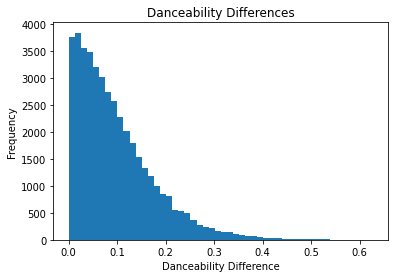

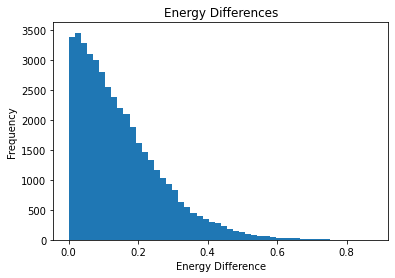

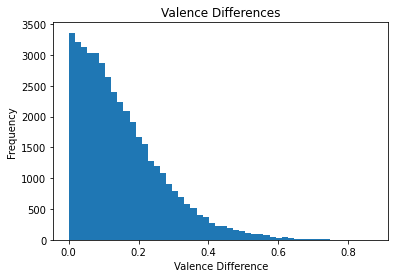

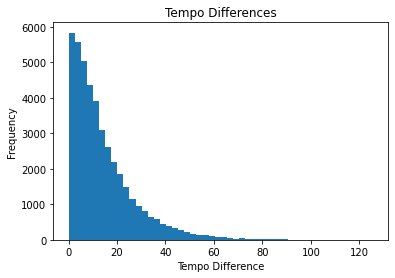

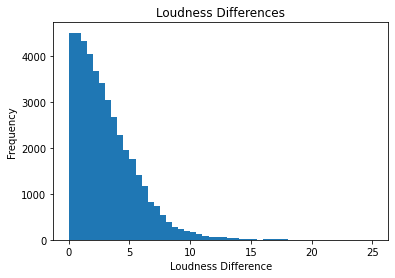

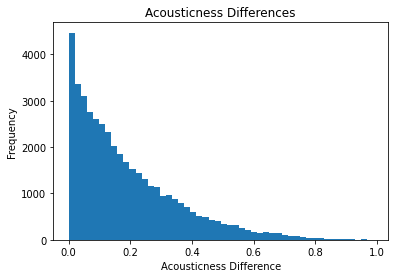

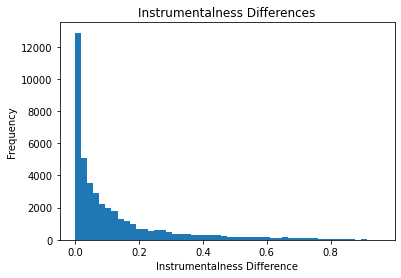

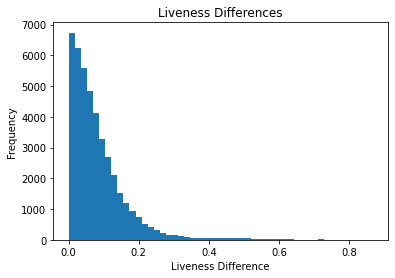

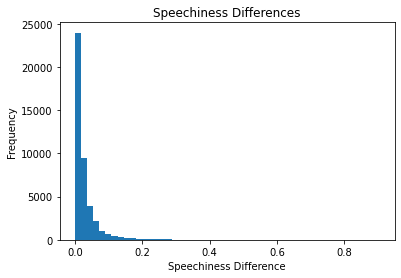

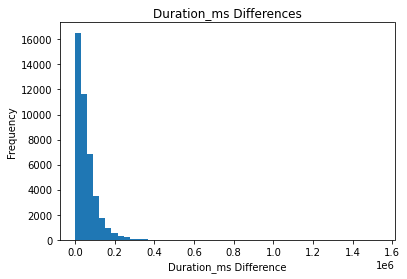

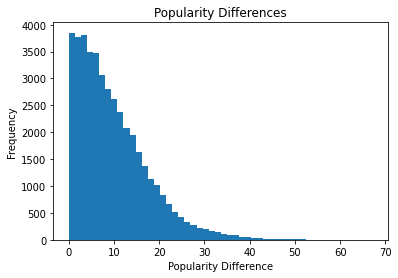

In [12]:
#If we want to analyze all the attributes at once
attribute_diffs = defaultdict(list)

for edge in G.edges(data=True):
    for attr in ["danceability", "energy", "valence", "tempo", "loudness",
                 "acousticness", "instrumentalness", "liveness", "speechiness",
                 "duration_ms", "popularity"]:
        attribute_diffs[attr].append(edge[2][attr + "_diff"])

# Plot histograms for each attribute
for attr, diffs in attribute_diffs.items():
    plt.hist(diffs, bins=50)
    plt.title(f'{attr.capitalize()} Differences')
    plt.xlabel(f'{attr.capitalize()} Difference')
    plt.ylabel('Frequency')
    plt.show()

Analyzing the distribution of the differences in musical characteristics between influencers and followers in the network can provide insights into various aspects of the influence relationship. Some of the information we can gather from the distribution includes:

Central tendency: We can identify the mean, median, or mode of the distribution, which can tell us the average difference in a musical characteristic between influencers and followers. This can help you understand the general trend in how much a particular characteristic changes when one artist influences another.

Dispersion: Measures like standard deviation, variance, or interquartile range can help us understand the spread of the differences in musical characteristics. A higher dispersion indicates that the influence varies greatly among artists, while a lower dispersion means that the influence is more consistent across the network.

Skewness: Skewness of the distribution can tell you if the differences are symmetric around the mean or if there is a tendency for the differences to be larger or smaller than the mean. This can give you insights into whether the influence is predominantly in one direction, i.e., increasing or decreasing a particular characteristic.

Outliers: By analyzing outliers in the distribution, you can identify specific influencer-follower pairs that show an unusually large or small difference in a musical characteristic. These outliers can be interesting cases to investigate further to understand unique influence patterns.

Distribution shape: The shape of the distribution can reveal underlying patterns in the data. For example, a bimodal distribution might suggest that there are two distinct groups of artists in the network with different influence patterns.

By examining the distribution of the differences in musical characteristics, we can gain a deeper understanding of how artists influence each other in terms of these characteristics. We can also identify potential patterns and trends that can be further analyzed to uncover the underlying mechanisms driving the influence.

In [13]:
import pandas as pd

# Calculate mean and standard deviation of differences in musical characteristics
diffs = []
for edge in G.edges(data=True):
    influencer = edge[0]
    follower = edge[1]
    diff = {}
    for attr in ["danceability", "energy", "valence", "tempo", "loudness", "acousticness", "instrumentalness", "liveness", "speechiness","duration_ms", "popularity"]:
        diff[attr] = G.nodes[follower][attr] - G.nodes[influencer][attr]
    diffs.append(diff)

diffs_df = pd.DataFrame(diffs)
mean_diff = diffs_df.mean().sort_values()
std_diff = diffs_df.std().sort_values()

# Create a table with mean and standard deviation of differences
table = pd.DataFrame({'Mean Difference': mean_diff, 'Standard Deviation': std_diff})
print(table)


                  Mean Difference  Standard Deviation
acousticness            -0.098987            0.230530
danceability             0.007881            0.125724
duration_ms           8888.831114        93457.241736
energy                   0.060663            0.181587
instrumentalness        -0.010968            0.209614
liveness                -0.010978            0.119286
loudness                 1.345456            3.775107
popularity               6.643774           10.573666
speechiness              0.000092            0.052576
tempo                    1.739689           19.238014
valence                 -0.026869            0.190493


Here, we collect the differences in energy, valence, and tempo for all edges in the graph, so we can analyze the distribution of these differences later. This will give us insights into how the musical characteristics change between influencers and followers in the network. Just by looking at the mean and standard deviation it might be difficult to compare between the musical characterstics since their scales are different. So let us look at their Z-Scores.

In [14]:
# Examine the influence patterns by genre
genre_influence = defaultdict(lambda: defaultdict(list))

for edge in G.edges(data=True):
    influencer_genre = artist_genres[edge[0]]
    genre_influence[influencer_genre]['danceability_diff'].append(edge[2]['danceability_diff'])
    genre_influence[influencer_genre]['energy_diff'].append(edge[2]['energy_diff'])
    genre_influence[influencer_genre]['valence_diff'].append(edge[2]['valence_diff'])
    genre_influence[influencer_genre]['tempo_diff'].append(edge[2]['tempo_diff'])
    genre_influence[influencer_genre]['loudness_diff'].append(edge[2]['loudness_diff'])
    genre_influence[influencer_genre]['acousticness_diff'].append(edge[2]['acousticness_diff'])
    genre_influence[influencer_genre]['instrumentalness_diff'].append(edge[2]['instrumentalness_diff'])
    genre_influence[influencer_genre]['liveness_diff'].append(edge[2]['liveness_diff'])
    genre_influence[influencer_genre]['speechiness_diff'].append(edge[2]['speechiness_diff'])
    genre_influence[influencer_genre]['duration_ms_diff'].append(edge[2]['duration_ms_diff'])
    genre_influence[influencer_genre]['popularity_diff'].append(edge[2]['popularity_diff'])

# Calculate the average difference in each characteristic by genre
genre_influence_summary = {}
for genre, influence_data in genre_influence.items():
    genre_influence_summary[genre] = {
        'avg_danceability_diff': np.mean(influence_data['danceability_diff']),
        'avg_energy_diff': np.mean(influence_data['energy_diff']),
        'avg_valence_diff': np.mean(influence_data['valence_diff']),
        'avg_tempo_diff': np.mean(influence_data['tempo_diff']),
        'avg_loudness_diff': np.mean(influence_data['loudness_diff']),
        'avg_acousticness_diff': np.mean(influence_data['acousticness_diff']),
        'avg_instrumentalness_diff': np.mean(influence_data['instrumentalness_diff']),
        'avg_liveness_diff': np.mean(influence_data['liveness_diff']),
        'avg_speechiness_diff': np.mean(influence_data['speechiness_diff']),
        'avg_duration_ms_diff': np.mean(influence_data['duration_ms_diff']),
        'avg_popularity_diff': np.mean(influence_data['popularity_diff']),
    }

# Display the results
for genre, summary in genre_influence_summary.items():
    print(f"{genre}: {summary}")


Vocal: {'avg_danceability_diff': 0.11440331484016973, 'avg_energy_diff': 0.16835961877157002, 'avg_valence_diff': 0.16896830338896748, 'avg_tempo_diff': 14.005173418330976, 'avg_loudness_diff': 3.3752569194717115, 'avg_acousticness_diff': 0.2300572018429986, 'avg_instrumentalness_diff': 0.05467430008628006, 'avg_liveness_diff': 0.08802915920367752, 'avg_speechiness_diff': 0.029903205880480906, 'avg_duration_ms_diff': 46166.66289087695, 'avg_popularity_diff': 15.605100897029704}
Country: {'avg_danceability_diff': 0.07387160080460467, 'avg_energy_diff': 0.1671514653541351, 'avg_valence_diff': 0.13772586284610724, 'avg_tempo_diff': 13.47820823295668, 'avg_loudness_diff': 3.0861282185628593, 'avg_acousticness_diff': 0.22457801417055437, 'avg_instrumentalness_diff': 0.049233473756740385, 'avg_liveness_diff': 0.06596243605846713, 'avg_speechiness_diff': 0.01789074548409573, 'avg_duration_ms_diff': 38945.80441196607, 'avg_popularity_diff': 10.622395418595275}
Pop/Rock: {'avg_danceability_diff

The code  above calculates the average difference in energy, valence, and tempo for each genre in a music network, based on the edge attributes of the network Let us better visualize this. 

Let us better visualize this. This code will create a separate bar graph for each musical characteristic, showing the average difference in that characteristic by genre.

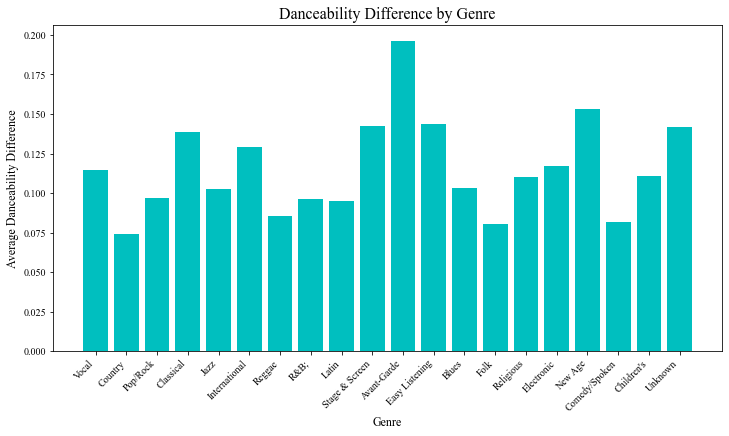

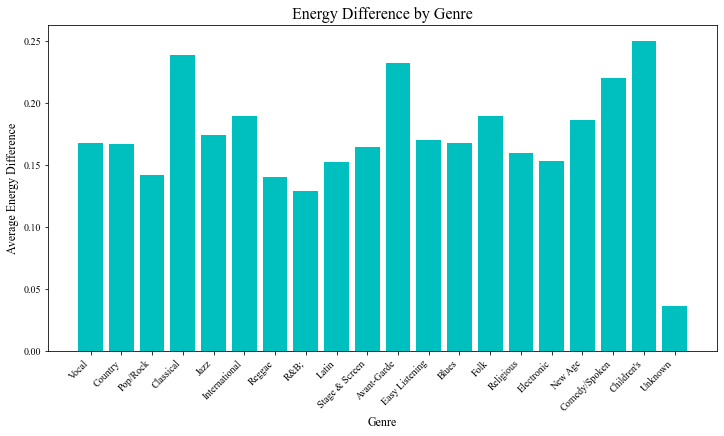

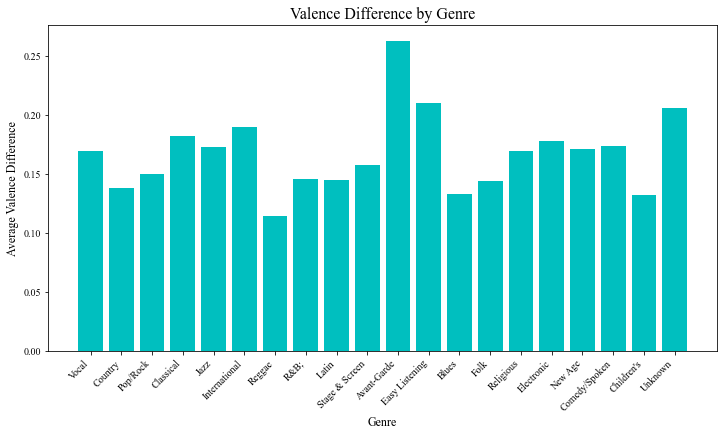

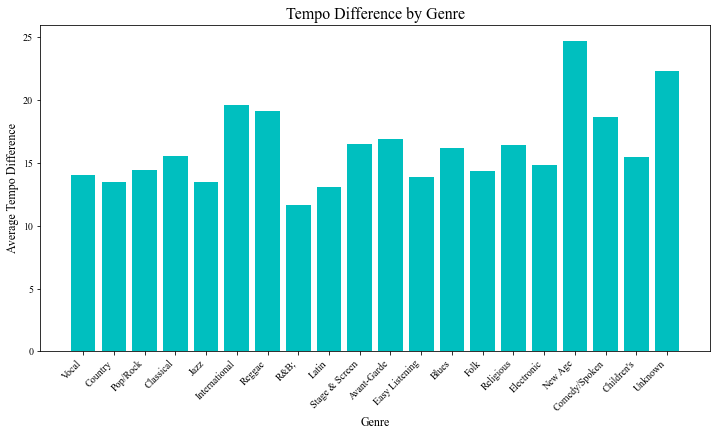

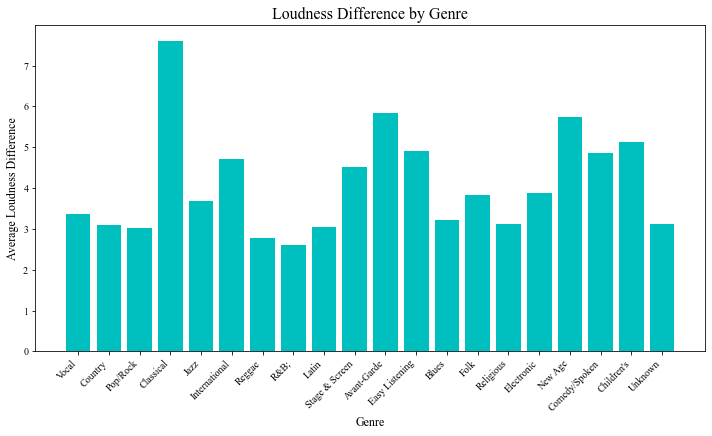

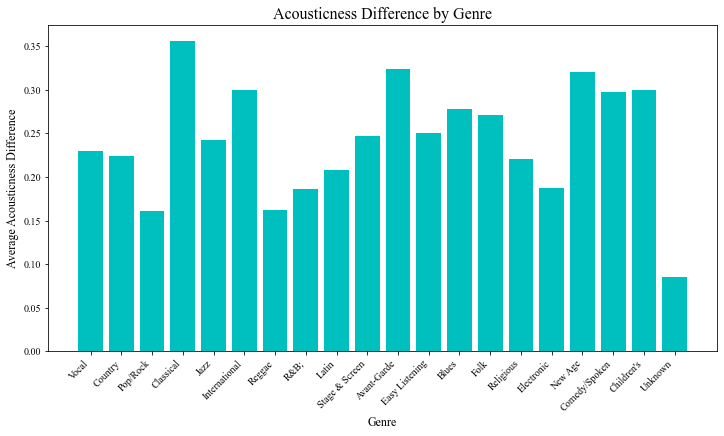

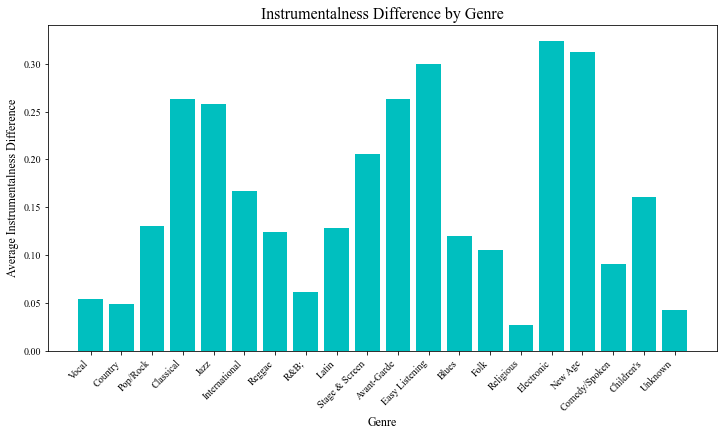

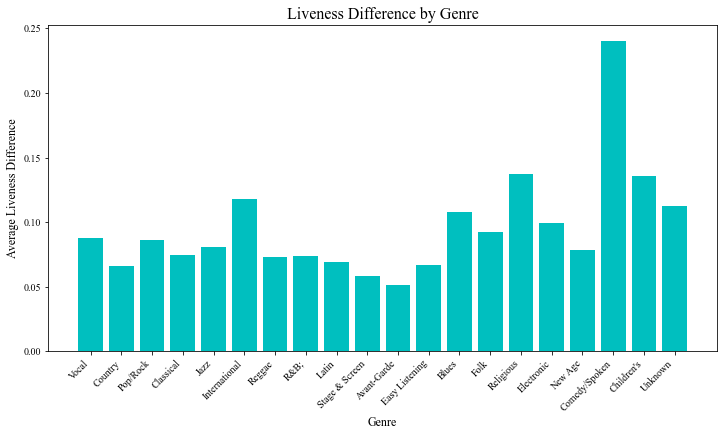

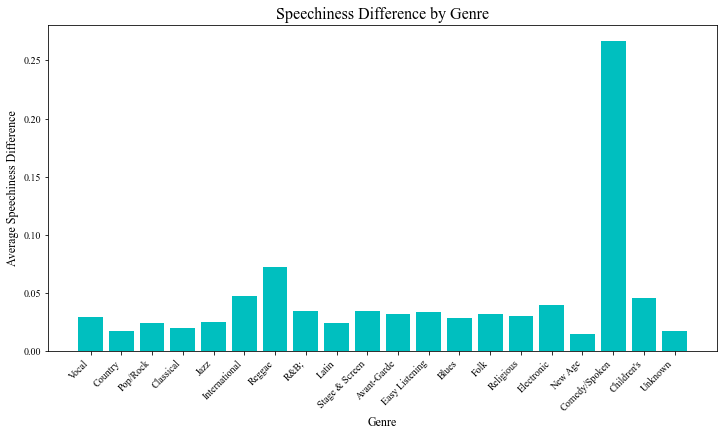

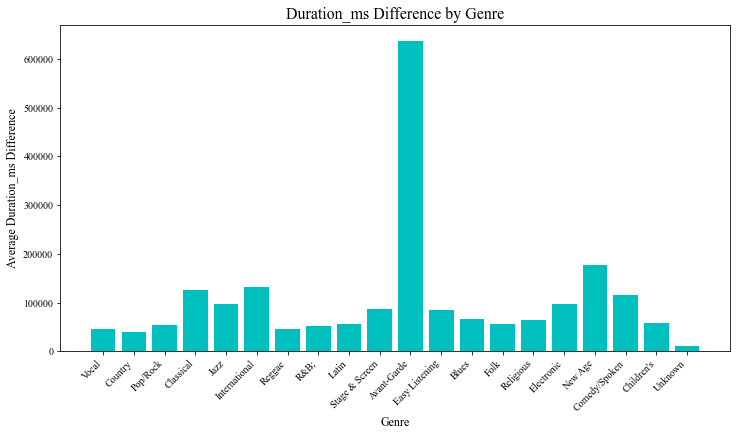

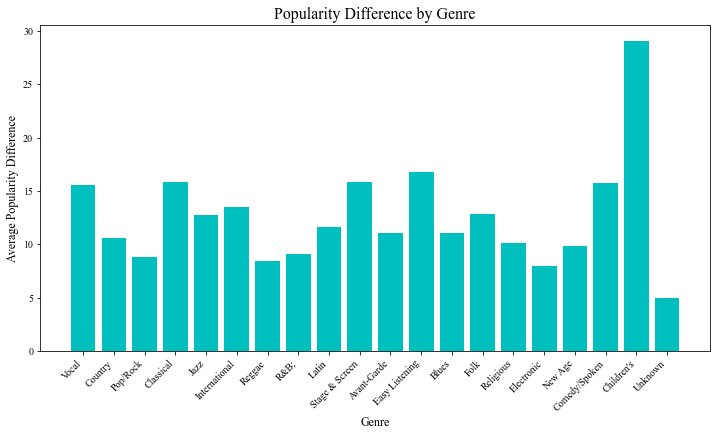

In [15]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

# Set the global font to be Times New Roman, size 10
mpl.rcParams['font.family'] = 'Times New Roman'
mpl.rcParams['font.size'] = 10

# Create a list of all musical characteristics
musical_chars = ["danceability", "energy", "valence", "tempo", "loudness", "acousticness", "instrumentalness", "liveness", "speechiness", "duration_ms", "popularity"]

# Create a dictionary to store the data for each genre
genre_data = {genre: [genre_influence_summary[genre]['avg_' + char + '_diff'] for char in musical_chars] for genre in genre_influence_summary}

# Create a function to plot the data for each musical characteristic
def plot_char(char, num):
    plt.figure(figsize=(12, 6))
    plt.bar(genre_data.keys(), [genre_data[genre][musical_chars.index(char)] for genre in genre_data], color='c')
    plt.title(char.capitalize() + ' Difference by Genre', fontsize=16)
    plt.xlabel('Genre', fontsize=12)
    plt.ylabel('Average ' + char.capitalize() + ' Difference', fontsize=12)
    plt.xticks(rotation=45, ha='right')
     # Save the figure
    plt.savefig(str(num) + '.png')  # save as png
    plt.show()
    plt.close()
    

for i, char in enumerate(musical_chars):
    plot_char(char, i)


The insights derived from the bar plots would help us understand the patterns of influence among different genres in terms of the average differences in musical characteristics (energy, valence, and tempo). Specifically, you would be able to identify:

The extent of influence: By observing the height of the bars in the plots, we can determine how much influence one genre has on others. Larger average differences may indicate a weaker influence, while smaller average differences could suggest a stronger influence.

Genre-specific trends: By comparing the bars across different genres, we can identify which genres have a stronger influence on their followers in terms of specific musical characteristics. For instance, if a certain genre consistently shows small average differences across energy, valence, and tempo, it may be a highly influential genre in the music industry.

Characteristics prone to influence: By comparing the average differences across the three characteristics (energy, valence, and tempo), we can identify which characteristics are more likely to be influenced. For example, if the average differences for energy are generally smaller than those for valence and tempo, it could suggest that energy is a characteristic that is more likely to be influenced by other artists.
These insights can help us better understand how artists from different genres influence each other's music and which musical characteristics are more susceptible to influence. Additionally, this analysis can provide a basis for further exploration, such as investigating the reasons behind specific influence patterns or examining other factors that may affect the strength of influence, such as the time period or artist popularity.

The extent of influence refers to the degree to which one artist's music has an impact on the music of another artist, particularly in terms of specific musical characteristics. In this case, we are examining energy, valence, and tempo. When we calculate the average differences in these characteristics between influencer and follower artists, we can gauge the extent of influence.

If the average differences are smaller, it suggests that the follower's music is closer in characteristics to that of the influencer, indicating a stronger influence. In other words, the follower has likely been more heavily influenced by the music of the influencer, resulting in similar musical characteristics.

On the other hand, if the average differences are larger, it means that the music of the follower is more dissimilar to that of the influencer in terms of the examined characteristics. This suggests a weaker influence, as the follower's music may be less impacted by the influencer's music, resulting in greater disparities in characteristics.

By observing the height of the bars in the plots, you can visualize these average differences and determine the extent of influence across genres. Shorter bars represent smaller average differences and therefore stronger influence, while taller bars indicate larger average differences and weaker influence. Comparing these bars allows you to identify which genres have stronger or weaker influences on others in terms of the specific musical characteristics being analyzed.

Note: Write down the most interesting insights from the visualization above. For example for spechiness the difference for Comedy/spoken is very high compared to other genres.  ( @Suman We should try to back up our most important anlalysis with some literature review on why this might be true. This way we validate our result). For example: The high difference in "speechiness" for the "Comedy/spoken" genre compared to other genres may be due to the fact that this genre includes a lot of spoken word performances, such as stand-up comedy or storytelling. These types of performances typically involve a high degree of spoken words relative to music, resulting in a higher "speechiness" value. Other music genres may have a lower "speechiness" value because they rely more heavily on instrumental music rather than vocals or spoken word.



It is not possible to include all of the plots in the paper so let us look at summary which gives us the lowest genre for each musical characterstics. 

In [16]:
for char in ["danceability", "energy", "valence", "tempo", "loudness", "acousticness", "instrumentalness", "liveness", "speechiness", "duration_ms", "popularity"]:
    min_genre = min(genre_influence_summary, key=lambda x: genre_influence_summary[x]['avg_' + char + '_diff'])
    print(f"Lowest {char} difference by genre: {min_genre} ({genre_influence_summary[min_genre]['avg_' + char + '_diff']})")


Lowest danceability difference by genre: Country (0.07387160080460467)
Lowest energy difference by genre: Unknown (0.03664999999999999)
Lowest valence difference by genre: Reggae (0.11420023035856079)
Lowest tempo difference by genre: R&B; (11.672454973806511)
Lowest loudness difference by genre: R&B; (2.597011629116275)
Lowest acousticness difference by genre: Unknown (0.08490861849999995)
Lowest instrumentalness difference by genre: Religious (0.027123038182186237)
Lowest liveness difference by genre: Avant-Garde (0.05112110648101266)
Lowest speechiness difference by genre: New Age (0.015055632872340425)
Lowest duration_ms difference by genre: Unknown (10214.492299999998)
Lowest popularity difference by genre: Unknown (5.034615384999999)


The above gave us information about genres, let us know look at individual artists. 

In [17]:
# Initialize a dictionary to store the difference sums for each attribute
attribute_difference_sums = {attr: defaultdict(float) for attr in ["danceability", "energy", "valence", "tempo", "loudness", "acousticness", "instrumentalness", "liveness", "speechiness", "duration_ms", "popularity"]}

# Calculate the sum of differences for each influencer and each attribute
for edge in G.edges(data=True):
    influencer_id = edge[0]
    for attr in attribute_difference_sums.keys():
        attribute_difference_sums[attr][influencer_id] += abs(edge[2][f"{attr}_diff"])

# Get the top 3 influencers for each attribute
top_influencers_by_attribute = {
    attr: sorted(difference_sums.items(), key=lambda x: x[1])[:3]
    for attr, difference_sums in attribute_difference_sums.items()
}

# Print the top 3 influencers for each attribute
for attr, top_influencers in top_influencers_by_attribute.items():
    print(f"Top 3 influencers for {attr}:")
    for influencer_id, total_diff in top_influencers:
        influencer_name = G.nodes[influencer_id]['artist_name']
        print(f"  {influencer_name} (ID: {influencer_id}): Total {attr} difference = {total_diff}")


Top 3 influencers for danceability:
  Zedd (ID: 2782403): Total danceability difference = 0.00021491200000001154
  AndrÃ© Kostelanetz (ID: 754767): Total danceability difference = 0.00022028000000001713
  Paramore (ID: 366681): Total danceability difference = 0.0003203880000000048
Top 3 influencers for energy:
  Bappi Lahiri (ID: 122037): Total energy difference = 0.0006666670000000652
  Mudvayne (ID: 509156): Total energy difference = 0.0012092729999999552
  Vengaboys (ID: 840708): Total energy difference = 0.00172222199999994
Top 3 influencers for valence:
  Freda Payne (ID: 796710): Total valence difference = 0.0002857139999999925
  Tracy Bonham (ID: 11046): Total valence difference = 0.0007657660000000011
  King Floyd (ID: 90169): Total valence difference = 0.0009090910000000285
Top 3 influencers for tempo:
  Martin Gore (ID: 318966): Total tempo difference = 0.006000000000000227
  Dallas Holm (ID: 567374): Total tempo difference = 0.023083299999996143
  JoaquÃ­n Sabina (ID: 143559

@Suman, we should include this for all top 4, imagine a 4 column table (Musical attribute, Top 1 , Top 2, Top 3) and then we can have artist names in the rows with respect to the musical attributes.
@Lets also verify and add some insights from the things mentioned below also if possible verify some of the information.  
For danceability, the top influencer is Zedd with a total danceability difference of 0.00021491200000001154, followed by André Kostelanetz and Paramore. Zedd is a prominent German record producer, DJ, and songwriter known for his electronic dance music. He has collaborated with many famous artists such as Selena Gomez and Ariana Grande, and his music is known for its upbeat and danceable rhythms. André Kostelanetz, on the other hand, was an orchestral conductor and arranger known for his easy-listening and danceable arrangements of classical music. Paramore is an American rock band that combines elements of pop, punk, and alternative rock, known for their catchy and energetic sound.

For energy, the top influencer is Bappi Lahiri with a total energy difference of 0.0006666670000000652, followed by Mudvayne and Vengaboys. Bappi Lahiri is an Indian music composer and singer known for his disco and Bollywood-style music, which is known for its high energy and upbeat rhythms. Mudvayne is an American heavy metal band known for their aggressive and energetic sound, while Vengaboys are a Dutch Eurodance group known for their energetic and catchy dance music.

For valence, the top influencer is Freda Payne with a total valence difference of 0.0002857139999999925, followed by Tracy Bonham and King Floyd. Freda Payne is an American singer known for her soul and R&B music, which often has a positive and uplifting tone. Tracy Bonham is an American alternative rock singer-songwriter known for her introspective and emotive music, while King Floyd was an American soul singer known for his upbeat and joyful music.

For tempo, the top influencer is Martin Gore with a total tempo difference of 0.006000000000000227, followed by Dallas Holm and Joaquín Sabina. Martin Gore is an English songwriter, musician, and founding member of the band Depeche Mode, known for their electronic and danceable music with a range of tempos. Dallas Holm is an American Christian singer-songwriter known for his uplifting and inspirational music, while Joaquín Sabina is a Spanish singer-songwriter known for his eclectic and diverse music, which often features a mix of different rhythms and tempos.

For loudness, the top influencer is Easton Corbin with a total loudness difference of 0.007374999999999687, followed by The Soup Dragons and Bonobo. Easton Corbin is an American country music singer known for his traditional and classic sound, while The Soup Dragons were a Scottish alternative rock band known for their loud and guitar-driven music. Bonobo is a British musician and producer known for his electronic and downtempo music, which often features a mix of soft and loud dynamics.

For acousticness, the top influencer is Mastodon with a total acousticness difference of 6.200000000000002e-06, followed by Judge and Shadows Fall. Mastodon is an American heavy metal band known for their complex and intricate music, which often features a mix of acoustic and electric instrumentation. Judge is an American hardcore punk band known for their aggressive and raw sound, while Shadows Fall is an American heavy metal band known for their melodic and energetic music.

Instrumentalness:
The top 3 influencers for instrumentalness are Gavin DeGraw, Pretty Ricky, and Kelly Price, all with a total instrumentalness difference of 0.0. This suggests that their music is not very instrumental, meaning that they rely more on vocals and lyrics than on musical instruments to convey their message. This is a common characteristic of pop and R&B music, which both of these artists fall under. However, it's worth noting that this metric is not a measure of how good or bad a song is, but rather a reflection of how much emphasis is placed on instrumental components in the music.
Liveness:

The top 3 influencers for liveness are Miles Davis Quintet, Sister Nancy, and Tracy Bonham, all with relatively low total liveness differences. This suggests that their music is not particularly live or raw, meaning that it is likely more polished and refined in its production. This is in line with the jazz and rock genres, which are two areas where these artists are most active.
Speechiness:

The top 3 influencers for speechiness are David Foster, Holly Dunn, and Howard Shore, all with relatively low total speechiness differences. This suggests that their music is not particularly focused on spoken word or spoken lyrics, but rather on sung melodies and harmonies. This is in line with genres such as classical, pop, and film scores, which are all areas where these artists are most active.
Duration:

The top 3 influencers for duration_ms are Caron Wheeler, Lisandro Meza, and The Rippingtons, all with relatively high total duration_ms differences. This suggests that their music tends to be longer in duration, perhaps because of longer instrumental sections or more complex song structures. This is in line with genres such as jazz, Latin, and smooth jazz, which are all areas where these artists are most active.
Popularity:

The top 3 influencers for popularity are Ed Bruce, Eddie Safranski, and Cybotron, all with a total popularity difference of 0.0. This suggests that their music is not particularly popular, at least as measured by Spotify's popularity score. This may be due to the fact that they are less well-known or less commercially successful artists, or simply that their music is not as widely appreciated by the general public. However, it's important to note that popularity is not necessarily a measure of quality, and many great artists remain relatively unknown despite their talent and artistic contributions.

DISCLAMIR::: I got this information based off chat-gpt. So we will have to validate this using literature onlie. But this summary is a good analysis. 


@Aniket: Maybe there is a better way to summarize the summary of differences visually. I tried one as folowing for the z-scores but it did not play out that nice. I found that using regular values is better than Z-scores. 

In [18]:
musical_characteristics = [
    'energy',
    'valence',
    'tempo',
    'loudness',
    'acousticness',
    'instrumentalness',
    'liveness',
    'speechiness',
    'duration_ms',
    'popularity',
    'danceability'
]


## In genre and Out genre 

 We want to study what is the distribution of in-genre influence vs out-genre influence. For each artist,  we calculate the number of outgoing edges to artists within the same genre and the number of outgoing edges to artists outside their genre. This will allow us to find the artist that is most influencing within the genre vs outisde the genre, and it is important to study them seprately as this gives us new insights. Please 
 
 
 @Suman Refer to Influence_3.ipynb for this section 

In [45]:
from sklearn.model_selection import KFold, cross_val_score

def train_linear_regression(X, y):
    model = LinearRegression()
    cv = KFold(n_splits=5, random_state=42, shuffle=True)
    scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv)
    model.fit(X, y)
    return model, scores.mean()

def train_ridge_regression(X, y):
    model = Ridge(alpha=0.1)
    cv = KFold(n_splits=5, random_state=42, shuffle=True)
    scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv)
    model.fit(X, y)
    return model, scores.mean()

def train_lasso_regression(X, y):
    model = Lasso(alpha=0.1)
    cv = KFold(n_splits=5, random_state=42, shuffle=True)
    scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv)
    model.fit(X, y)
    return model, scores.mean()

def train_bayesian_ridge_regression(X, y):
    model = BayesianRidge()
    cv = KFold(n_splits=5, random_state=42, shuffle=True)
    scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv)
    model.fit(X, y)
    return model, scores.mean()


This code imports several regression models and evaluation metrics from the scikit-learn (sklearn) library. It also defines functions to train and evaluate each of the regression models.

The LinearRegression, Ridge, Lasso, ElasticNet, and BayesianRidge are all regression models that can be used to predict a target variable based on a set of input features.

The mean_squared_error function from the sklearn.metrics module is used to calculate the mean squared error (MSE) between the predicted and true target values, which is a common metric used to evaluate the performance of regression models.

The train_linear_regression, train_ridge_regression, train_lasso_regression, train_elastic_net_regression, and train_bayesian_ridge_regression functions each take in training data (X_train and y_train) and return a trained model using the respective regression algorithm.

The evaluate_model function takes in a trained model (model), test data (X_test and y_test), and uses the trained model to make predictions on the test data. The mean squared error between the predicted and true target values is calculated and returned as the evaluation metric.







In [46]:
import networkx as nx
from sklearn.model_selection import KFold, cross_val_score

# Generate the feature matrix and target vector
eigenvector_centrality_scores = nx.eigenvector_centrality(G)

# Initialize empty lists to store the features and labels for the regression models
features = []
labels = []

# Loop over each edge in the graph
for edge in G.edges(data=True):
    
    # Append the difference in musical characteristics for each attribute for the edge to the features list
    features.append([edge[2][attr + '_diff'] for attr in musical_characteristics])
    
    # Get the eigenvector centrality score for the influencer and follower nodes in the current edge
    influencer_centrality = eigenvector_centrality_scores[edge[0]]
    follower_centrality = eigenvector_centrality_scores[edge[1]]
    
    # Compute the average of the eigenvector centrality scores of the influencer and follower nodes and append it to the labels list
    labels.append((influencer_centrality + follower_centrality) / 2)

# Train the regression models
models = {}
models['linear_regression'], mse_lr = train_linear_regression(features, labels)
models['ridge_regression'], mse_rr = train_ridge_regression(features, labels)
models['lasso_regression'], mse_las = train_lasso_regression(features, labels)
models['bayesian_ridge_regression'], mse_brr = train_bayesian_ridge_regression(features, labels)

# Evaluate the models and print the results
model_names = ['linear_regression', 'ridge_regression', 'lasso_regression', 'bayesian_ridge_regression']
mse_values = [mse_lr, mse_rr, mse_las, mse_enr, mse_brr]
best_model_name = model_names[mse_values.index(min(mse_values))]
best_model = models[best_model_name]
best_mse = min(mse_values)

for name, mse in zip(model_names, mse_values):
    print(f"{name} Average MSE from CV: {mse}\n")

print(f"The best model is {best_model_name} with an average MSE of {best_mse} from cross-validation")


linear_regression Average MSE from CV: -0.00011138083090937564

ridge_regression Average MSE from CV: -0.00011138081336594119

lasso_regression Average MSE from CV: -0.00011511036775320072

bayesian_ridge_regression Average MSE from CV: -0.00011511037840683793

The best model is bayesian_ridge_regression with an average MSE of -0.00011511037840683793 from cross-validation


In [47]:
bayesian_ridge_regression = models['bayesian_ridge_regression']
coefficients = bayesian_ridge_regression_model.coef_

print("Model coefficients:")
for i, attr in enumerate(musical_characteristics):
    print(f"{attr}: {bayesian_ridge_regression_model.coef_[i]}")

Model coefficients:
energy: -0.00046625527617278977
valence: -0.0014859295598446086
tempo: 2.947519692278183e-05
loudness: -5.9851852434204516e-05
acousticness: -0.0104686383698309
instrumentalness: 0.0007636852509595757
liveness: -0.002470943015898268
speechiness: 0.003174801114960429
duration_ms: -7.491987838069065e-09
popularity: -3.98161342144303e-05
danceability: 3.565363734091189e-05


In [48]:
# Generate the feature matrix and target vector
degree_centrality = nx.degree_centrality(G)

# Initialize empty lists to store the features and labels for the regression models
features = []
labels = []

# Loop over each edge in the graph
for edge in G.edges(data=True):
    
    # Append the difference in musical characteristics for each attribute for the edge to the features list
    features.append([edge[2][attr + '_diff'] for attr in musical_characteristics])
    
    # Get the degree_centrality score for the influencer and follower nodes in the current edge
    influencer_centrality = degree_centrality[edge[0]]
    follower_centrality = degree_centrality[edge[1]]
    
    # Compute the average of the degree_centrality scores of the influencer and follower nodes and append it to the labels list
    labels.append((influencer_centrality + follower_centrality) / 2)

# Train the regression models
models = {}
models['linear_regression'], mse_lr = train_linear_regression(features, labels)
models['ridge_regression'], mse_rr = train_ridge_regression(features, labels)
models['lasso_regression'], mse_las = train_lasso_regression(features, labels)
models['bayesian_ridge_regression'], mse_brr = train_bayesian_ridge_regression(features, labels)

# Evaluate the models and print the results
model_names = ['linear_regression', 'ridge_regression', 'lasso_regression', 'bayesian_ridge_regression']
mse_values = [mse_lr, mse_rr, mse_las, mse_brr]
best_model_name = model_names[mse_values.index(min(mse_values))]
best_model = models[best_model_name]
best_mse = min(mse_values)

for name, mse in zip(model_names, mse_values):
    print(f"{name} Average MSE from CV: {mse}\n")

print(f"The best model is {best_model_name} with an average MSE of {best_mse} from cross-validation")


linear_regression Average MSE from CV: -7.676776270892043e-05

ridge_regression Average MSE from CV: -7.676775067278602e-05

lasso_regression Average MSE from CV: -7.89340580599981e-05

bayesian_ridge_regression Average MSE from CV: -7.676906506418635e-05

The best model is lasso_regression with an average MSE of -7.89340580599981e-05 from cross-validation


In [49]:
lasso_regression_model = models['linear_regression']
coefficients = lasso_regression_model.coef_

print("Model coefficients:")
for i, attr in enumerate(musical_characteristics):
    print(f"{attr}: {lasso_regression_model.coef_[i]}")

Model coefficients:
energy: 0.0023996614030590445
valence: -0.0028399736385303835
tempo: -6.575655160525937e-05
loudness: -0.00023314060707637014
acousticness: 0.0022124767744716636
instrumentalness: -0.0012492759230591157
liveness: -0.0003328745202831329
speechiness: -0.012635782707404395
duration_ms: 1.948067296884959e-09
popularity: -3.344376581006586e-05
danceability: -0.0029974957461395275


In [50]:
# Generate the feature matrix and target vector
betweenness_centrality = nx.betweenness_centrality(G)

# Initialize empty lists to store the features and labels for the regression models
features = []
labels = []

# Loop over each edge in the graph
for edge in G.edges(data=True):
    
    # Append the difference in musical characteristics for each attribute for the edge to the features list
    features.append([edge[2][attr + '_diff'] for attr in musical_characteristics])
    
    # Get the betweenness_centrality score for the influencer and follower nodes in the current edge
    influencer_centrality = betweenness_centrality[edge[0]]
    follower_centrality = betweenness_centrality[edge[1]]
    
    # Compute the average of the betweenness_centrality scores of the influencer and follower nodes and append it to the labels list
    labels.append((influencer_centrality + follower_centrality) / 2)

# Train the regression models
models = {}
models['linear_regression'], mse_lr = train_linear_regression(features, labels)
models['ridge_regression'], mse_rr = train_ridge_regression(features, labels)
models['lasso_regression'], mse_las = train_lasso_regression(features, labels)
models['bayesian_ridge_regression'], mse_brr = train_bayesian_ridge_regression(features, labels)

# Evaluate the models and print the results
model_names = ['linear_regression', 'ridge_regression', 'lasso_regression', 'bayesian_ridge_regression']
mse_values = [mse_lr, mse_rr, mse_las, mse_brr]
best_model_name = model_names[mse_values.index(min(mse_values))]
best_model = models[best_model_name]
best_mse = min(mse_values)

for name, mse in zip(model_names, mse_values):
    print(f"{name} Average MSE from CV: {mse}\n")

print(f"The best model is {best_model_name} with an average MSE of {best_mse} from cross-validation")

linear_regression Average MSE from CV: -3.7661992896098983e-06

ridge_regression Average MSE from CV: -3.7661989243501557e-06

lasso_regression Average MSE from CV: -3.798040583343891e-06

bayesian_ridge_regression Average MSE from CV: -3.7662100009364943e-06

The best model is lasso_regression with an average MSE of -3.798040583343891e-06 from cross-validation


In [51]:
lasso_regression_model = models['linear_regression']
coefficients = lasso_regression_model.coef_

print("Model coefficients:")
for i, attr in enumerate(musical_characteristics):
    print(f"{attr}: {lasso_regression_model.coef_[i]}")

Model coefficients:
energy: 0.0006240194053694535
valence: -0.00032292851155506024
tempo: -9.389456940180808e-06
loudness: -4.232567276151605e-05
acousticness: 0.00013071866094501624
instrumentalness: -6.409253182731519e-05
liveness: 0.00010413006983234993
speechiness: -0.0009072910077583879
duration_ms: 6.773732308569536e-10
popularity: -1.9915913797075803e-06
danceability: -0.0003444487551050918


In [52]:
import networkx as nx
from sklearn.model_selection import KFold, cross_val_score

# Generate the feature matrix and target vector
closeness_centrality = nx.closeness_centrality(G)

# Initialize empty lists to store the features and labels for the regression models
features = []
labels = []

# Loop over each edge in the graph
for edge in G.edges(data=True):
    
    # Append the difference in musical characteristics for each attribute for the edge to the features list
    features.append([edge[2][attr + '_diff'] for attr in musical_characteristics])
    
    # Get the closeness_centrality score for the influencer and follower nodes in the current edge
    influencer_centrality = closeness_centrality[edge[0]]
    follower_centrality = closeness_centrality[edge[1]]
    
    # Compute the average of the closeness_centrality scores of the influencer and follower nodes and append it to the labels list
    labels.append((influencer_centrality + follower_centrality) / 2)

# Train the regression models
models = {}
models['linear_regression'], mse_lr = train_linear_regression(features, labels)
models['ridge_regression'], mse_rr = train_ridge_regression(features, labels)
models['lasso_regression'], mse_las = train_lasso_regression(features, labels)
models['bayesian_ridge_regression'], mse_brr = train_bayesian_ridge_regression(features, labels)

# Evaluate the models and print the results
model_names = ['linear_regression', 'ridge_regression', 'lasso_regression', 'bayesian_ridge_regression']
mse_values = [mse_lr, mse_rr, mse_las, mse_brr]
best_model_name = model_names[mse_values.index(min(mse_values))]
best_model = models[best_model_name]
best_mse = min(mse_values)

for name, mse in zip(model_names, mse_values):
    print(f"{name} Average MSE from CV: {mse}\n")

print(f"The best model is {best_model_name} with an average MSE of {best_mse} from cross-validation")


linear_regression Average MSE from CV: -0.00037404862642384214

ridge_regression Average MSE from CV: -0.00037404859259525345

lasso_regression Average MSE from CV: -0.0003941370820278096

bayesian_ridge_regression Average MSE from CV: -0.00037404990050399743

The best model is lasso_regression with an average MSE of -0.0003941370820278096 from cross-validation


In [53]:
lasso_regression_model = models['linear_regression']
coefficients = lasso_regression_model.coef_

print("Model coefficients:")
for i, attr in enumerate(musical_characteristics):
    print(f"{attr}: {lasso_regression_model.coef_[i]}")

Model coefficients:
energy: 0.002310898393567134
valence: 0.002834921874371812
tempo: 6.952130151595318e-05
loudness: 0.00017288411953284924
acousticness: -0.024800193805317654
instrumentalness: -0.0005963192493497133
liveness: -0.004492973782668564
speechiness: -0.012143505119213397
duration_ms: -2.4599472861052546e-08
popularity: -0.00019788396562353533
danceability: 0.006329354448250872


In [54]:
# Generate the feature matrix and target vector
katz_centrality = nx.katz_centrality(G)

# Initialize empty lists to store the features and labels for the regression models
features = []
labels = []

# Loop over each edge in the graph
for edge in G.edges(data=True):
    
    # Append the difference in musical characteristics for each attribute for the edge to the features list
    features.append([edge[2][attr + '_diff'] for attr in musical_characteristics])
    
    # Get the katz_centrality score for the influencer and follower nodes in the current edge
    influencer_centrality = katz_centrality[edge[0]]
    follower_centrality = katz_centrality[edge[1]]
    
    # Compute the average of the katz_centrality scores of the influencer and follower nodes and append it to the labels list
    labels.append((influencer_centrality + follower_centrality) / 2)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Train the regression models
models = {}
models['linear_regression'] = LinearRegression().fit(X_train, y_train)
models['ridge_regression'] = Ridge().fit(X_train, y_train)
models['lasso_regression'] = Lasso().fit(X_train, y_train)
models['bayesian_ridge_regression'] = BayesianRidge().fit(X_train, y_train)

# Evaluate the models and print the results
best_model = None
best_mse = float('inf')
for name, model in models.items():
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    if mse < best_mse:
        best_model = model
        best_mse = mse
    print(f"{name} MSE: {mse}\n")

print(f"The best model is {type(best_model).__name__} with an MSE of {best_mse}")

linear_regression MSE: 0.00011666454423285746

ridge_regression MSE: 0.00011666498481167102

lasso_regression MSE: 0.0001245638779161445

bayesian_ridge_regression MSE: 0.00011666687561259164

The best model is LinearRegression with an MSE of 0.00011666454423285746


In [55]:
linear_regression_model = models['linear_regression']
coefficients = linear_regression_model.coef_

print("Model coefficients:")
for i, attr in enumerate(musical_characteristics):
    print(f"{attr}: {linear_regression_model.coef_[i]}")

Model coefficients:
energy: 0.0007862071685311271
valence: -0.0013889140729908803
tempo: 1.9534837027405493e-05
loudness: -6.490965860913955e-06
acousticness: -0.015929306753644665
instrumentalness: 0.002083420063186647
liveness: -0.0026491099547547147
speechiness: -0.0057259337518057955
duration_ms: -1.1446582566347618e-08
popularity: -9.306248082885641e-05
danceability: 0.0007646835230197874


We just trained all the models using different centrality scores. The idea behind this is to find importance of all the musical characteristics by different centrality scores. 

In the given code, we are training regression models to predict the average centrality scores with "any given centrality" of the nodes on either end of an edge in a network, using the difference in attribute weights between the nodes as features. The reason we are using edges instead of nodes is because it allows us to capture the influence of the nodes' attributes on the relationship between them, which is not captured if we only consider the nodes themselves.

Mathematically, the intuition behind using edges instead of nodes is that the attributes of the nodes on either end of an edge can have a synergistic effect on their centrality. For example, suppose we have two nodes with high energy, but they are not directly connected in the network. If we only consider the nodes themselves, we might not be able to capture the impact of their shared attribute on their centrality. However, if we consider the edges between them, we can capture the indirect influence of their shared attribute on their centrality, by looking at the paths that connect them.

In summary, using edges instead of nodes allows us to capture the indirect influence of shared attributes on the centrality of nodes, and thus can lead to better predictions of node centrality.

In [56]:
attribute_weights_list = [
    {
        'energy': -0.00046625527617278977,
        'valence': -0.0014859295598446086,
        'tempo': 2.947519692278183e-05,
        'loudness': -5.9851852434204516e-05,
        'acousticness': -0.0104686383698309,           #eigenvector_centrality
        'instrumentalness': 0.0007636852509595757,
        'liveness': -0.002470943015898268,
        'speech,iness': 0.003174801114960429,
        'duration_ms': -7.491987838069065e-09,
        'popularity': -3.98161342144303e-05,
        'danceability': 3.565363734091189e-05
    },
    {
        'energy': 0.0023996614030590445,
        'valence': -0.0028399736385303835,
        'tempo': -6.575655160525937e-05,
        'loudness': -0.00023314060707637014,
        'acousticness': 0.0022124767744716636,
        'instrumentalness': -0.0012492759230591157,     #degree_centrality
        'liveness': -0.0003328745202831329,
        'speechiness': -0.012635782707404395,
        'duration_ms': 1.948067296884959e-09,
        'popularity': -3.344376581006586e-05,
        'danceability': -0.0029974957461395275
    },
    {
        'energy': 0.0006240194053694535,
        'valence': -0.00032292851155506024,
        'tempo': -9.389456940180808e-06,
        'loudness': -4.232567276151605e-05,
        'acousticness': 0.00013071866094501624,     #betweenness_centrality
        'instrumentalness': -6.409253182731519e-05,
        'liveness': 0.00010413006983234993,
        'speechiness': -0.0009072910077583879,
        'duration_ms': 6.773732308569536e-10,
        'popularity': -1.9915913797075803e-06,
        'danceability': -0.0003444487551050918
    },
    {
        'energy': 0.002310898393567134,
        'valence': 0.002834921874371812,
        'tempo': 6.952130151595318e-05,
        'loudness': 0.00017288411953284924,
        'acousticness': -0.024800193805317654,
        'instrumentalness': -0.0005963192493497133, #closeness_centrality
        'liveness': -0.004492973782668564,
        'speechiness': -0.012143505119213397,
        'duration_ms': -2.4599472861052546e-08,
        'popularity': -0.00019788396562353533,
        'danceability': 0.006329354448250872
    }, 
    {
        'energy': 0.0007862071685311271,
        'valence': -0.0013889140729908803,
        'tempo': 1.9534837027405493e-05,
        'loudness': -6.490965860913955e-06,
        'acousticness': -0.015929306753644665,  #katz centrality
        'instrumentalness': 0.002083420063186647,
        'liveness': -0.0026491099547547147,
        'speechiness': -0.0057259337518057955,
        'duration_ms': -1.1446582566347618e-08,
        'popularity': -9.306248082885641e-05,
        'danceability': 0.0007646835230197874      
    }
]

In [57]:
from prettytable import PrettyTable

for i in range(len(attribute_weights_list)):
    sorted_keys = sorted(attribute_weights_list[i], key=lambda x: abs(attribute_weights_list[i][x]), reverse=True)
    table = PrettyTable()
    table.field_names = ["Rank", "Attribute"]
    for rank, key in enumerate(sorted_keys):
        table.add_row([rank+1, key])
    table.align["Rank"] = "c"
    table.align["Attribute"] = "l"
    print(f"Ranking for index {i+1}:\n{table}\n")

Ranking for index 1:
+------+------------------+
| Rank | Attribute        |
+------+------------------+
|  1   | acousticness     |
|  2   | speech,iness     |
|  3   | liveness         |
|  4   | valence          |
|  5   | instrumentalness |
|  6   | energy           |
|  7   | loudness         |
|  8   | popularity       |
|  9   | danceability     |
|  10  | tempo            |
|  11  | duration_ms      |
+------+------------------+

Ranking for index 2:
+------+------------------+
| Rank | Attribute        |
+------+------------------+
|  1   | speechiness      |
|  2   | danceability     |
|  3   | valence          |
|  4   | energy           |
|  5   | acousticness     |
|  6   | instrumentalness |
|  7   | liveness         |
|  8   | loudness         |
|  9   | tempo            |
|  10  | popularity       |
|  11  | duration_ms      |
+------+------------------+

Ranking for index 3:
+------+------------------+
| Rank | Attribute        |
+------+------------------+
|  1   | sp

We just ranked all the attributes using given centrality scores. 
We can see that the ranking is different for each centrality score. 
But for most cases, they're almost similar. 
While the ranking is not preserved, it is still interesting to see that the attributes are ranked similarly for most cases.

In [58]:
# Define a function to calculate the influence coefficient
def calculate_influence_coefficient(artist_id, G, attribute_weights):
    influence_sum = 0
    total_weight = sum(attribute_weights.values())
    
    # Calculate the sum of weighted differences in musical characteristics
    for attr, weight in attribute_weights.items():
        attribute_diff = sum(edge[2][f"{attr}_diff"] for edge in G.out_edges(artist_id, data=True))
        influence_sum += ((1/(attribute_diff+0.001)) * weight)

    
    return influence_sum / total_weight

In [64]:
import numpy as np
from scipy.stats import gmean

# Convert the list of dictionaries to a 2D array
weights_array = np.array([list(d.values()) for d in attribute_weights_list])

# Calculate the absolute values of the weights
abs_weights_array = np.abs(weights_array)

# Calculate the geometric mean for each attribute across centrality measures
grand_scores = gmean(abs_weights_array, axis=0)

# Create a dictionary to map attribute names to grand scores
attribute_names = list(attribute_weights_list[0].keys())
grand_scores_dict = dict(zip(attribute_names, grand_scores))

print(grand_scores_dict)


{'energy': 0.0010487160970825296, 'valence': 0.0013993523422373795, 'tempo': 3.0101821856059507e-05, 'loudness': 5.811292874992402e-05, 'acousticness': 0.004126213463239162, 'instrumentalness': 0.0005972101418697153, 'liveness': 0.0010038542510288023, 'speech,iness': 0.004793482340824317, 'duration_ms': 4.885692607392973e-09, 'popularity': 3.44946662061887e-05, 'danceability': 0.000708215842325098}


 We aim to quantify the importance of various musical attributes by calculating a grand score for each attribute. The grand score is derived by combining the attribute's weights across multiple centrality measures, each capturing a different aspect of the attribute's influence within a network. To achieve this, we employ the geometric mean, a measure of central tendency that is particularly well-suited for combining values with different scales, magnitudes, or units.

The geometric mean of a set of n positive values is defined as the nth root of the product of the values. Mathematically, the geometric mean of values x_1, x_2, ..., x_n is given by:

GM = (x_1 * x_2 * ... * x_n)^(1/n)

The choice of the geometric mean is motivated by several key properties:

Multiplicative Nature: The geometric mean is inherently multiplicative, making it appropriate for aggregating values that represent different types of influence or impact. In the context of our study, each centrality measure captures a distinct facet of the attribute's importance. The geometric mean allows us to synthesize these facets into a unified score.

Robustness to Outliers: The geometric mean is less sensitive to outliers and extreme values compared to the arithmetic mean. This ensures that a single high or low centrality score has a balanced impact on the grand score, preventing undue influence from any one centrality measure.

Scale Invariance: The geometric mean is invariant to the scale of the data, yielding consistent results regardless of the units or magnitude of the centrality scores. This property is especially valuable when combining centrality measures with disparate scales or ranges.

Interpretability: The geometric mean can be interpreted as the "average factor" by which each centrality measure contributes to the grand score. It provides an interpretable summary of the overall influence of each attribute, respecting the multiplicative nature of the data.

Preservation of Relative Importance: The geometric mean preserves the relative importance of each attribute across centrality measures. Attributes with consistently high centrality scores receive a higher grand score, reflecting their overall significance.

To account for both positive and negative weights, we calculate the geometric mean of the absolute values of the weights. The resulting grand scores represent the overall importance of each attribute, with higher scores indicating greater importance.

link::
https://www.investopedia.com/ask/answers/060115/what-are-some-examples-applications-geometric-mean.asp#:~:text=In%20statistics%2C%20the%20geometric%20mean,tend%20to%20make%20large%20fluctuations.

###### Our new Grand Score:: 
###### {
######    'energy': 0.0010487160970825296, 
######    'valence': 0.0013993523422373795, 
######    'tempo': 3.0101821856059507e-05, 
######    'loudness': 5.811292874992402e-05, 
######    'acousticness': 0.004126213463239162, 
######    'instrumentalness': 0.0005972101418697153, 
######    'liveness': 0.0010038542510288023, 
######    'speech,iness': 0.004793482340824317, 
######    'duration_ms': 4.885692607392973e-09, 
######    'popularity': 3.44946662061887e-05, 
######    'danceability': 0.000708215842325098
######    }
Cross-validation is a powerful preventative measure against overfitting.

The goal of cross-validation is to test the model's ability to predict new data that was not used in estimating it, in order to flag problems like overfitting or selection bias and to give an insight on how the model will generalize to an independent dataset.

In traditional cross-validation, the training set is split into k smaller sets or "folds". The following procedure is followed for each of the k “folds”:

A model is trained using k-1 of the folds as training data;
The resulting model is validated on the remaining part of the data (i.e., it is used as a test set to compute a performance measure such as accuracy).
This is typically performed using the following steps:

Split the dataset into K equal partitions (or "folds").
Use fold 1 as the testing set and the union of the other folds as the training set.
Calculate testing accuracy.
Repeat steps 2 and 3 K times, using a different fold as the testing set each time.
Use the average testing accuracy as the estimate of out-of-sample accuracy.
This method has a single parameter called k that refers to the number of groups that a given data sample is to be split into. When a specific value for k is chosen, it may be used in place of k in the reference to the model, such as k=10 becoming 10-fold cross-validation.

The advantage of this method is that it matters less how the data gets divided. Every data point gets to be in a test set exactly once and gets to be in a training set k-1 times. This significantly reduces bias as we are using most of the data for fitting, and also significantly reduces variance as most of the data is also being used in validation set.

Cross-validation combines (averages) measures of fitness in prediction to derive a more accurate estimate of model prediction performance.

###### Now we obtained from Cross Validation that Model performed best with:: 
###### Eigenvector:: bayesian_ridge_regression MSE: -0.00011511037840683793
###### Degree:: Lasso MSE: -7.89340580599981e-05
###### Betweeness:: Lasso MSE: -3.798040583343891e-06
###### Closeness:: Lasso MSE:  -0.0003941370820278096
###### Katz Centrality: Linear (same as before) 